# Generative Adversarial Networks

Last lecture we covered Variational AutoEncoders (VAEs) as an example of a "generative" network.  While "generative" has a specific meaning in computer science, it is colloquially used to refer to an algorithm that "generates" samples similar to those it has been trained on.

VAEs learned to encode training data into vectors in an N-dimensional normal distribution.  The space spanned by those vectors can then be sampled to produce new images that are consistent with the originals.  This training was achieved by constructing a loss function that simultaneously encouraged the reconstructed outputs to look like the inputs AND forced the activation of the bottleneck layer to look like that of a Gaussian.

Generative Adversarial Networks (GANs) do something similar: they also compare training images with reconstructed output, but the details of how they work are completely different!

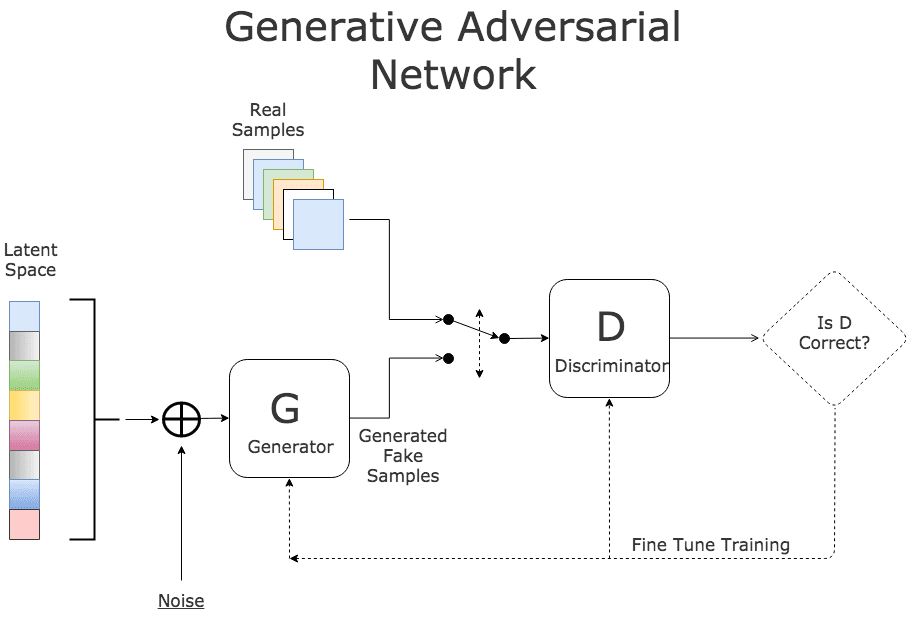

GANs are composed of two separate networks, a **Generator** and a **Discriminator**.  
* The Generator takes a D-dimensional vector $\vec{z}$ as input, and produces some reconstructed output (e.g. an image).  Unlike with VAEs, $p(\vec{z})$ is usually a uniform distribution, not an N-dimensional Gaussian.
* The Discriminator distinguishes between the output from the Generator and the training data.  

The training of this model is also broken into two steps:
* Discriminator training learns to distinguish between Generator output and training data.  It is a binary classifier.
* Generator training learns from the Discriminator: it is encouraged to do a better job of "fooling" the Discriminator by producing output that's more consistent with the training data.

Note that the Generator never sees the training data directly!  This makes GAN's rather immune from overfitting, though GAN's pose a number of other challenges that we'll discuss below.

We use a loss function defined as:

$$\min_{G} \max_{D} L(D,G) = \mathbb{E}_{\vec{x}}\left[\log D(\vec{x})\right] + \mathbb{E}_{\vec{z}}\left[\log(1-D(G(\vec{z}))\right]$$

where:

* $\mathbb{E}_{\vec{x}}\left[\log D(\vec{x})\right]$ encourages the network to learn to identify real images ($\vec{x}$)
* $\mathbb{E}_{\vec{z}}\left[\log(1-D(G(\vec{z}))\right]$ encourages the network to learn to identify fake images ($D(G(\vec{z}))$).

Note that the discriminator is trained to *maximize* the objective (i.e. moves the combined model towards $p(\vec{z}) \neq p(\vec{x})$), while the generator is trained to *minimize* the objective (i.e. moves the combined model towards $p(\vec{z})=p(\vec{x})$).  Hence the competing $\min_{G}\max_{D}$ expression in the combined objective function. When the generator is being trained, the parameters of the discriminator are held fixed, and vice versa.

Both of these terms compete on roughly equal footing, which sometimes keeps the network from converging.  This is the "adversarial" part of the GAN -- the generator and discriminator need to compete with each other, and if one becomes significantly stronger than the other then the GAN either won't converge or will converge to a bad place.

Adversarial techniques arose out of an observation that small changes to an input image can sometimes have outsized effects on their classification:

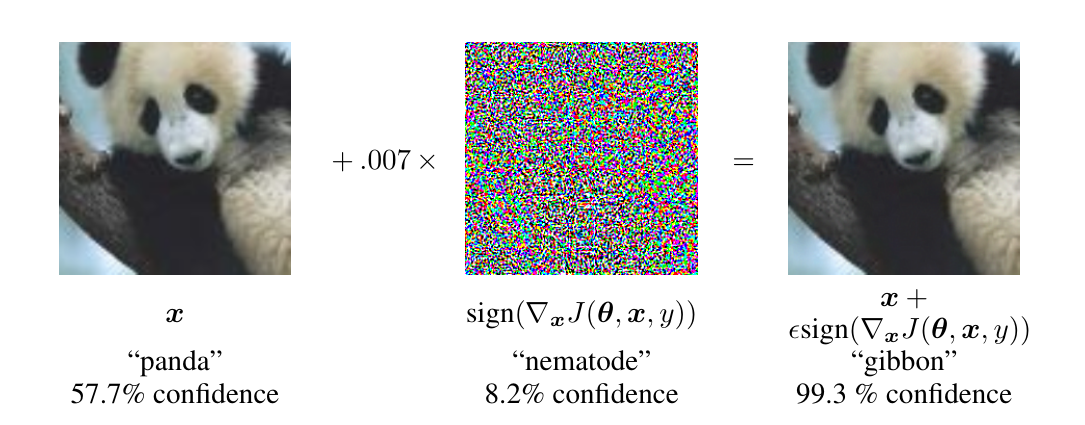

Occasionally/often we'll see that the discriminator is too strong, which can be helped by replacing gradient descent of $\mathbb{E}_{\vec{z}}\left[\log(1-D(G(\vec{z}))\right]$ with gradient *ascent* of $\mathbb{E}_{\vec{z}}\left[\log(D(G(\vec{z}))\right]$.

We also sometimes will see that the GAN just generates the same image (with small variations) over and over again.  e.g. if the GAN was trained on images of dogs and cats, but always produces images of dogs.  Even if the images of dogs are very realistic, the GAN is still failing to generate any images of cats.  This is called "mode collapse".

Successfully training GAN's can be tricky, and often requires things like "label smoothing" (which some of you used on HW2!) and "batch normalization" to get things exactly right.  
* Batch normalization: re-scaling the outputs from a layer to provide more consistent inputs to the next layer.  This helps to avoid a situation where the output weights are a "moving target" as inputs to the next layer.
* Label smoothing: regularlization technique used with cross-entropy losses and softmax activation (e.g. multi-category classification) that introduces some noise into the classification outputs to avoid over-fitting.

## Interpreting GANs

Stealing this quote from Yann LeCun, on one way to interpret what a GAN is doing:

> ... the key component [of the GAN] is the generator, and the discriminator plays the role of a trainable objective function. Let us imagine that the data lies on a manifold. Until the generator produces samples that are recognized as being on the manifold, it gets a gradient indicating how to modify its output so it could approach the manifold. In such scenario, the discriminator acts to punish the generator when it produces samples that are outside the manifold. This can be understood as a way to train the generator with a set of possible desired outputs (e.g. the manifold) instead of a single desired output as in traditional supervised learning.

## MLP GAN

Let's start by implementing a fairly straightforward GAN architecture, with a single hidden layer between the latent layer and the output.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import time
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

We'll use the MNIST dataset from last lecture:

In [2]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())

IMG_SHAPE = (1, 28, 28)
IMG_SIZE = 1
for x in IMG_SHAPE:
    IMG_SIZE *= x

We'll create our model below.  Note the use of `LeakyReLU` activation functions, which help to stabilize the adversarial training.  We also have a large dropout (0.5) for both the generator and discriminator, which also helps with stability.

In [3]:
LATENT_DIM = 100

class GAN(torch.nn.Module):

    def __init__(self):
        super(GAN, self).__init__()
        
        
        self.generator = nn.Sequential(
            nn.Linear(LATENT_DIM, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, IMG_SIZE),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            nn.Linear(IMG_SIZE, 128),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(128, 1),
            
            # need sigmoid activation since loss function for this example won't include it
            nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [4]:
# Hyperparameters
random_seed = 123
generator_learning_rate = 0.001
discriminator_learning_rate = 0.001
num_epochs = 20
batch_size = 128

In [5]:
torch.manual_seed(random_seed)

model = GAN()
model = model.to(device)

optim_gener = torch.optim.Adam(model.generator.parameters(),     lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False)

In [7]:
start_time = time.time()    

discr_costs = []
gener_costs = []
for epoch in range(num_epochs):
    epoch_start_time=time.time()
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        # Normalize images from [0,1] to [-1, 1] range
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 
        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        

        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features)
        
        # loss function doesn't include a sigmoid activation
        gener_loss = F.binary_cross_entropy(discr_pred, valid)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(-1, IMG_SIZE))
        real_loss = F.binary_cross_entropy(discr_pred_real, valid)
        
        discr_pred_fake = model.discriminator_forward(generated_features.detach())
        fake_loss = F.binary_cross_entropy(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        
        
    ### LOGGING
    print ('Epoch: %03d/%03d | Gen/Dis Loss: %.4f/%.4f | Time= %.2f s' 
            %(epoch+1, num_epochs, gener_loss, discr_loss,
              (time.time()-epoch_start_time)))

print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/020 | Gen/Dis Loss: 2.4398/0.0982 | Time= 9.69 s
Epoch: 002/020 | Gen/Dis Loss: 0.5984/0.6418 | Time= 9.36 s
Epoch: 003/020 | Gen/Dis Loss: 0.8281/0.5483 | Time= 9.03 s
Epoch: 004/020 | Gen/Dis Loss: 0.7415/0.6296 | Time= 9.81 s
Epoch: 005/020 | Gen/Dis Loss: 0.6072/0.6682 | Time= 9.96 s
Epoch: 006/020 | Gen/Dis Loss: 0.5614/0.6199 | Time= 9.39 s
Epoch: 007/020 | Gen/Dis Loss: 1.2366/0.4570 | Time= 9.95 s
Epoch: 008/020 | Gen/Dis Loss: 0.9925/0.4691 | Time= 10.75 s
Epoch: 009/020 | Gen/Dis Loss: 1.5095/0.3939 | Time= 10.01 s
Epoch: 010/020 | Gen/Dis Loss: 1.2073/0.4959 | Time= 10.33 s
Epoch: 011/020 | Gen/Dis Loss: 1.0292/0.5346 | Time= 10.22 s
Epoch: 012/020 | Gen/Dis Loss: 1.1668/0.5978 | Time= 9.44 s
Epoch: 013/020 | Gen/Dis Loss: 1.0203/0.5082 | Time= 9.73 s
Epoch: 014/020 | Gen/Dis Loss: 1.5442/0.4434 | Time= 9.53 s
Epoch: 015/020 | Gen/Dis Loss: 1.1241/0.5132 | Time= 9.95 s
Epoch: 016/020 | Gen/Dis Loss: 1.1028/0.5494 | Time= 8.84 s
Epoch: 017/020 | Gen/Dis Loss: 1.001

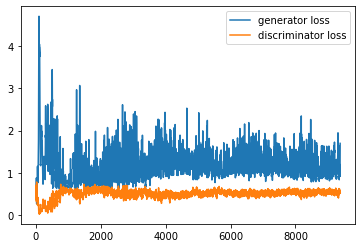

In [8]:
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.show()

We can make some new images using the GAN.  Note that this time we're sampling from a uniform distribution, not a Gaussian like with VAEs:

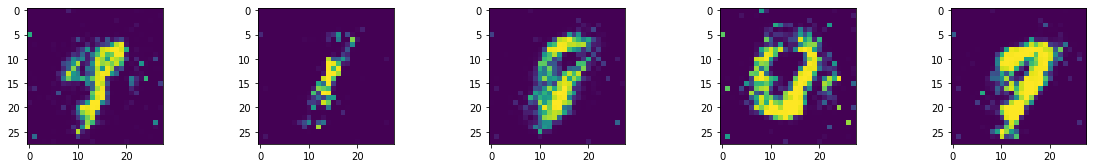

In [9]:
model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))

for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach())

We probably could have squeezed some more out of this algorithm by running for more epochs, but ultimately this is a bit too limiting of a setup.

## Convolutional GAN

Now let's implement a GAN with all the bells and whistles.  We'll use convolutional layers instead of linear layers, and we'll use batch normalization and label smoothing to improve the stability.

In [10]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class Reshape1(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), 64, 7, 7)


class FancyGAN(torch.nn.Module):

    def __init__(self):
        super(FancyGAN, self).__init__()
        
        
        self.generator = nn.Sequential(
              
            nn.Linear(LATENT_DIM, 3136, bias=False),
            nn.BatchNorm1d(num_features=3136),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            Reshape1(),
            
            # remember, the 'generator' piece is going from encoding to image, not going from image to encoding.  
            # so we use ConvTranspose2d instead of Conv2d
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            
            # Batch normalization
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            # played with adding some dropout, doesn't seem to help in this example.
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(3, 3), stride=(2, 2), padding=1, bias=False),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=(3, 3), stride=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001),
            #nn.Dropout2d(p=0.2),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(2, 2), stride=(1, 1), padding=0, bias=False),
            nn.Tanh()
        )
        
        self.discriminator = nn.Sequential(
            
            # The discriminator goes from image to encoding, so uses Conv2d.
            nn.Conv2d(in_channels=1, out_channels=8, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=8),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            nn.Conv2d(in_channels=8, out_channels=32, padding=1, kernel_size=(3, 3), stride=(2, 2), bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(inplace=True, negative_slope=0.0001), 
            #nn.Dropout2d(p=0.2),
            
            Flatten(),

            nn.Linear(7*7*32, 1),
            
            # We'll call the BCE loss function below, which applies a sigmoid activation function.
            # so we don't need to call it here.
            #nn.Sigmoid()
        )

            
    def generator_forward(self, z):
        img = self.generator(z)
        return img
    
    def discriminator_forward(self, img):
        pred = model.discriminator(img)
        return pred.view(-1)

In [11]:
torch.manual_seed(random_seed)

model = FancyGAN()
model = model.to(device)

print(model)

FancyGAN(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=3136, bias=False)
    (1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.0001, inplace=True)
    (3): Reshape1()
    (4): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.0001, inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.0001, inplace=True)
    (10): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.0001, inplace=True)
    (13): ConvTranspose2

Set up the optimizers.  Note that the learning rate is going to be smaller in this example -- having too large of a learning rate can cause the two loss functions to change too quickly, and get them out of balance:

In [12]:
generator_learning_rate = 0.0001
discriminator_learning_rate = 0.0001

optim_gener = torch.optim.Adam(model.generator.parameters(), lr=generator_learning_rate)
optim_discr = torch.optim.Adam(model.discriminator.parameters(), lr=discriminator_learning_rate)

In [13]:
start_time = time.time()    

num_epochs=60
discr_costs = []
gener_costs = []
for epoch in range(num_epochs):
    epoch_start_time=time.time()
    model = model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):

        
        # Normalize images to [-1, 1] range
        features = (features - 0.5)*2.
        features = features.view(-1, IMG_SIZE).to(device) 

        targets = targets.to(device)

        valid = torch.ones(targets.size(0)).float().to(device)
        fake = torch.zeros(targets.size(0)).float().to(device)
        

        # --------------------------
        # Train Generator
        # --------------------------
        
        # Make new images
        z = torch.zeros((targets.size(0), LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
        generated_features = model.generator_forward(z)
        
        # Loss for fooling the discriminator
        discr_pred = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28))
        
        # loss function includes sigmoid activation
        gener_loss = F.binary_cross_entropy_with_logits(discr_pred, valid*0.9)
        
        optim_gener.zero_grad()
        gener_loss.backward()
        optim_gener.step()
        
        # --------------------------
        # Train Discriminator
        # --------------------------        
        
        discr_pred_real = model.discriminator_forward(features.view(targets.size(0), 1, 28, 28))
        real_loss = F.binary_cross_entropy_with_logits(discr_pred_real, valid*0.9)
        
        discr_pred_fake = model.discriminator_forward(generated_features.view(targets.size(0), 1, 28, 28).detach())
        fake_loss = F.binary_cross_entropy_with_logits(discr_pred_fake, fake)
        
        discr_loss = 0.5*(real_loss + fake_loss)

        optim_discr.zero_grad()
        discr_loss.backward()
        optim_discr.step()        
        
        discr_costs.append(discr_loss.item())
        gener_costs.append(gener_loss.item())
        
    ### LOGGING
    print ('Epoch: %03d/%03d | Gen/Dis Loss: %.4f/%.4f | Time= %.2f s' 
            %(epoch+1, num_epochs, gener_loss, discr_loss,
              (time.time()-epoch_start_time)))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/060 | Gen/Dis Loss: 1.5113/0.3710 | Time= 105.09 s
Epoch: 002/060 | Gen/Dis Loss: 1.4028/0.3923 | Time= 106.62 s
Epoch: 003/060 | Gen/Dis Loss: 1.1835/0.4866 | Time= 115.64 s
Epoch: 004/060 | Gen/Dis Loss: 1.0408/0.5270 | Time= 109.41 s


KeyboardInterrupt: 

In [ ]:
plt.plot(range(len(gener_costs)), gener_costs, label='generator loss')
plt.plot(range(len(discr_costs)), discr_costs, label='discriminator loss')
plt.legend()
plt.show()

In [ ]:
model.eval()
# Make new images
z = torch.zeros((5, LATENT_DIM)).uniform_(-1.0, 1.0).to(device)
generated_features = model.generator_forward(z)
imgs = generated_features.view(-1, 28, 28)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 2.5))


for i, ax in enumerate(axes):
    axes[i].imshow(imgs[i].to(torch.device('cpu')).detach(), cmap='binary')

## Energy Based GANs

GANs as implemented above are often unstable and difficult to train, so significant amount of work has gone into modifying GANs in ways that make them less fragile.

One such approach is to replace the Discriminator with an AutoEncoder that learns to encode/reconstruct the output image:

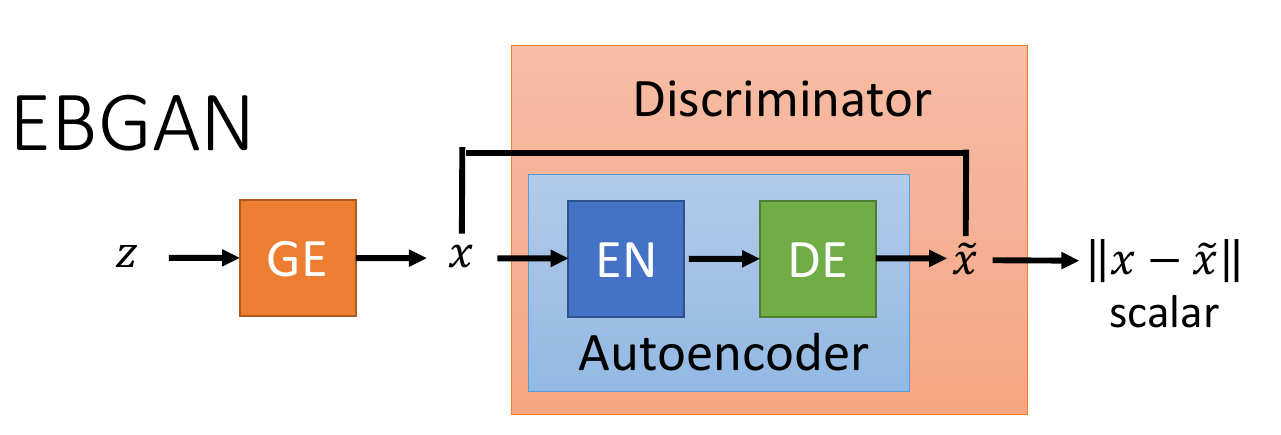

and then the discriminator is trained using a loss function that looks like:

$$ L_D(\vec{x},\vec{z}) = D(\vec{x}) + \max(0,m-D(G(\vec{z})))$$

where $m$ is an "energy" that is required to be greater than 0.  We then train the Generator to minimize

$$ L_G(\vec{z}) = D(G(\vec{z})) $$

In this setup, desired configurations (where $G(\vec{z})$ produces outputs similar to $\vec{x}$) are assigned low energies through training, while undesirable configurations are assigned higher energies.

Note that *supervised* learning falls within this paradigm of "energy minimization" where the role of the "energy" is played by the loss function that quantifies the difference between the prediction and the target.  In *unsupervised* learning, we attribute lower energies to the data manifold.

We will have more to say about energy-based models and converting energies into probabilities (e.g. via Gibbs distributions) in the coming weeks!

References:
* [Unsupervised deep learning (Kirkby; Machine Learning and Statistics)](https://github.com/dkirkby/MachineLearningStatistics/blob/3aa7385e1fd0b1572013bdf1f1c823806b744b2d/notebooks/UnsupervisedDeep.ipynb)
* Erdmann et al.; Deep Learning for Physics Research
* Goodfellow et al.; [Deep Learning](https://www.deeplearningbook.org/)
* ["How to train a GAN"](https://github.com/soumith/ganhacks)
* [The GAN Zoo](https://github.com/hindupuravinash/the-gan-zoo)
* [From GAN to WGAN](https://lilianweng.github.io/posts/2017-08-20-gan/)
* [Explaining and Harnessing Adversarial Examples](https://arxiv.org/abs/1412.6572)
* [Energy-based Generative Adversarial Network](https://arxiv.org/abs/1609.03126)